In [1]:
import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


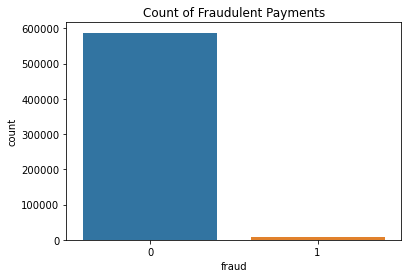

Number of normal examples:  587443
Number of fradulent examples:  7200


In [3]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())

In [4]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


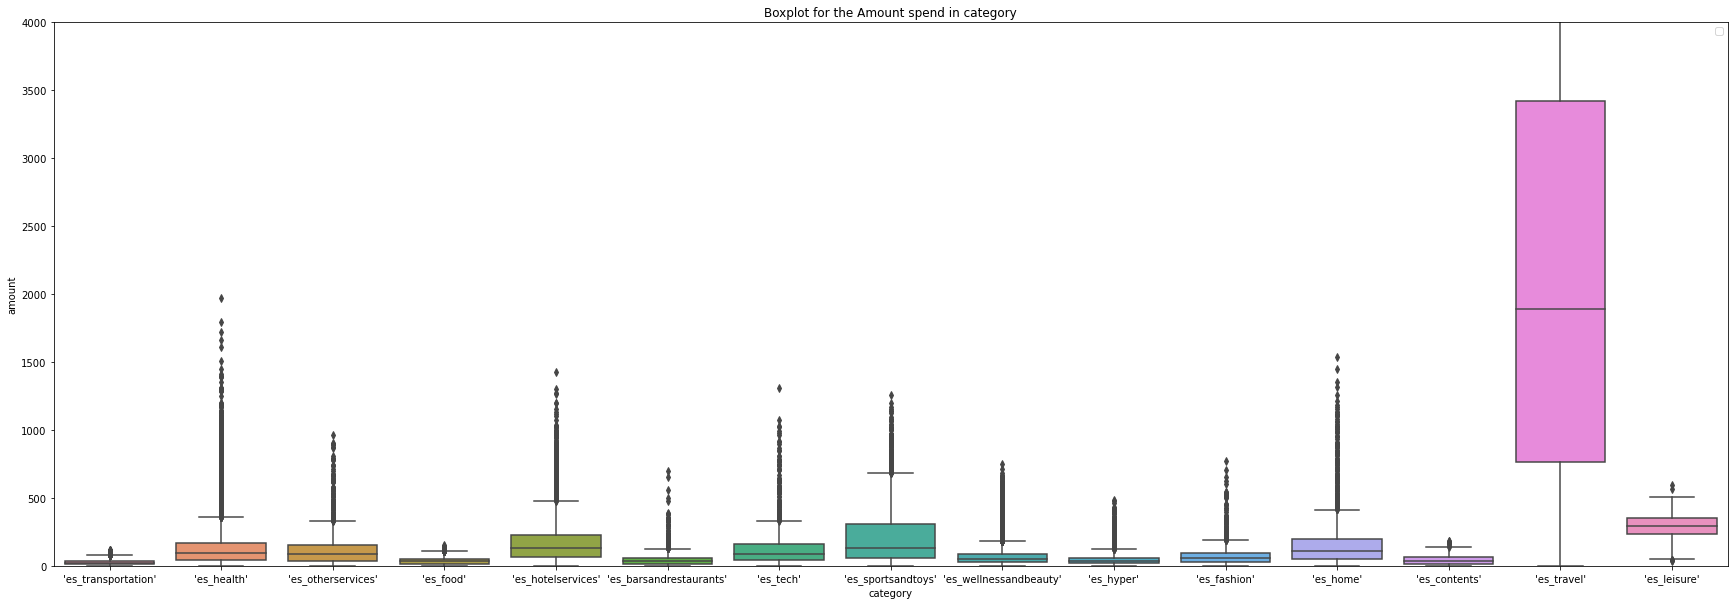

In [5]:
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

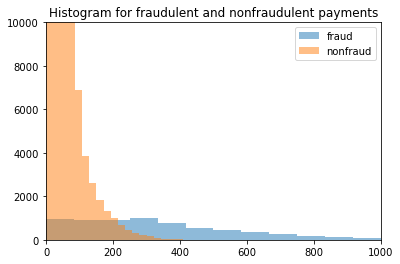

In [6]:
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [7]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


In [8]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [9]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [10]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [11]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(y[y==1].count())

7200


In [12]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [15]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


In [16]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))

C:\Users\AAA\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


In [17]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))

C:\Users\AAA\AppData\Local\Temp\ipykernel_8896\2623409382.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


In [18]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))

[23:43:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174047   2186]
 [   706 175527]]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=42,
    test_size=0.3)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test,
    random_state=42,
    test_size=0.3)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_valid.shape}, {y_valid.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (416250, 7), (416250,)
Validation set: (124875, 7), (124875,)
Test set: (53518, 7), (53518,)


In [20]:
model = KNeighborsClassifier(n_neighbors=5,p=1)
model = model.fit(X_train, y_train)

In [21]:
y_hat_train = model.predict(X_train)
y_hat_valid = model.predict(X_valid)
y_hat_test = model.predict(X_test)

In [22]:
print('K Neighbors Classifier')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')

K Neighbors Classifier
Training Set
[[410770    396]
 [  1739   3345]]
Accuracy: 0.995
Precision: 0.894
Recall: 0.658
F1-score: 0.758

Validation Set
[[123221    168]
 [   563    923]]
Accuracy: 0.994
Precision: 0.846
Recall: 0.621
F1-score: 0.716

Test Set
Accuracy: 0.994
F1-score: 0.703


In [23]:
model = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,verbose=1,class_weight="balanced")
model = model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.5s finished


In [24]:
y_hat_train = model.predict(X_train)
y_hat_valid = model.predict(X_valid)
y_hat_test = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [25]:
print('Random Forest Classifier')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')

Random Forest Classifier
Training Set
[[395164  16002]
 [    45   5039]]
Accuracy: 0.961
Precision: 0.239
Recall: 0.991
F1-score: 0.386

Validation Set
[[118630   4759]
 [    16   1470]]
Accuracy: 0.962
Precision: 0.236
Recall: 0.989
F1-score: 0.381

Test Set
Accuracy: 0.961
F1-score: 0.373


In [26]:
model = XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)
model = model.fit(X_train, y_train)

[23:46:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [27]:
y_hat_train = model.predict(X_train)
y_hat_valid = model.predict(X_valid)
y_hat_test = model.predict(X_test)

In [28]:
print('XGBoost')
print('Training Set')
print(confusion_matrix(y_true=y_train, y_pred=y_hat_train))
print(f'Accuracy: {accuracy_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Precision: {precision_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'Recall: {recall_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print(f'F1-score: {f1_score(y_true=y_train, y_pred=y_hat_train):.3f}')
print('')
print('Validation Set')
print(confusion_matrix(y_true=y_valid, y_pred=y_hat_valid))
print(f'Accuracy: {accuracy_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Precision: {precision_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'Recall: {recall_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print(f'F1-score: {f1_score(y_true=y_valid, y_pred=y_hat_valid):.3f}')
print('\nTest Set')
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_hat_test):.3f}')
print(f'F1-score: {f1_score(y_true=y_test, y_pred=y_hat_test):.3f}')

XGBoost
Training Set
[[410866    300]
 [  1059   4025]]
Accuracy: 0.997
Precision: 0.931
Recall: 0.792
F1-score: 0.856

Validation Set
[[123273    116]
 [   326   1160]]
Accuracy: 0.996
Precision: 0.909
Recall: 0.781
F1-score: 0.840

Test Set
Accuracy: 0.996
F1-score: 0.812
